# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
from itertools import permutations
from itertools import combinations
from pyEDM import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import time
import os
import math
import random
from scipy.stats import ttest_ind

from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

import warnings
warnings.filterwarnings("ignore", 
    message="A worker stopped while some jobs were given to the executor.",
    module="joblib.externals.loky.process_executor")

# Load Data

In [3]:
# Load data
data = pd.read_csv('../Data/Five_Species_Coupled_Food_Chain_Model_res_13.csv', index_col=0).iloc[:30000,1:]

# Load uniform noise and noise scaling factors
noise = pd.read_csv('../Data/uniform_noise.csv', index_col=0)
with open('../Data/noise_scaling.pkl', 'rb') as file:
    noise_scaling = pickle.load(file)

# # Load all embeddings - keys are (target, E, Tp, gap_radius)
with open('../Data/all_embeddings_1_lag.pkl', 'rb') as file:
    all_embeddings = pickle.load(file)  

# Load libraries
with open('../Data/libraries.pkl', 'rb') as file:
    libraries = pickle.load(file)

# Define Functions

In [5]:
def get_noisy_data(data, noise_level, noise, noise_scaling):
    
    if noise_level == 0:
        noisy_data = data.copy()
        noise_levels = {col: 0 for col in data.columns}
        
    else:
        # Get noise scaling
        noise_scalings = {}
        for var in data.columns:
            row = noise_scaling[noise_scaling.target==var]['coefficients']

            a = noise_scaling[noise_scaling.target==var]['coefficients'].item()[2]
            b = noise_scaling[noise_scaling.target==var]['coefficients'].item()[1]
            c = noise_scaling[noise_scaling.target==var]['intercept'].item()
            c = c - noise_level

            # Calculate the discriminant
            discriminant = b**2 - 4*a*c

            # Two real solutions
            root1 = (-b + np.sqrt(discriminant)) / (2*a)
            root2 = (-b - np.sqrt(discriminant)) / (2*a)
            roots = (root1, root2)

            # Calculate noise_range from quadratic relationship
            noise_scalings['{0}'.format(var)] = root1

        # Add scaled noise to data
        scaled_noise = noise.iloc[data.index,:].copy()
        for var, scaling in noise_scalings.items():
            scaled_noise[var] *= scaling

        noisy_data = data + scaled_noise
        noisy_data[noisy_data<0] = 0

        # Record noise levels of each variable
        noise_levels = {}
        for var in noisy_data.columns:
            noise_before = noisy_data[var] - data[var]
            noise_power = np.mean(noise_before**2)
            signal_power = np.mean(data[var]**2)
            noise_level = np.sqrt(noise_power / signal_power)
            noise_levels['{0}'.format(var)] = noise_level
    
    return noisy_data, noise_levels

In [7]:
def get_block(data, num_lags=1, tau=1):
    ''' Get a dataframe with all the possible valid lags of the variables. '''
    
    backward_lags = pd.concat([data[var].shift(lag*tau).rename(f'{var}(t-{lag*tau})') for lag in range(num_lags+1) for var in data.columns], axis=1)
    forward_lags  = pd.concat([data[var].shift(-1*lag*tau).rename(f'{var}(t+{lag*tau})') for lag in range(1,num_lags+1) for var in data.columns], axis=1)
    block = pd.concat([backward_lags, forward_lags], axis=1)
    
    return block

In [9]:
def get_valid_lags(all_lags, target, gap_radius, Tp):
    
    system_variables = ['R', 'C1', 'C2', 'P1', 'P2']
    
    valid_lags = all_lags.copy()
    
    # If Tp = 0, remove [-gap_radius, gap_radius] lags of target variable from valid_lags
    if Tp == 0:
        for r in range(-gap_radius, gap_radius+1):
            if r < 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t{r})']
            elif r == 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t-{r})']
            elif r > 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t+{r})']
            
    # If Tp != 0, remove sgn(Tp)*[1,2r+1] lags of all variables from valid lags
    elif Tp != 0:
        sgn_Tp = int(math.copysign(1, Tp))
        lags_to_remove = [sgn_Tp * l for l in list(range(1,2*gap_radius+1 + 1))]
        for lag in lags_to_remove:
            for var in system_variables:
                if lag < 0:
                    valid_lags = [x for x in valid_lags if x != f'{var}(t{lag})']
                elif lag == 0:
                    valid_lags = [x for x in valid_lags if x != f'{var}(t-{lag})']
                elif lag > 0:
                    valid_lags = [x for x in valid_lags if x != f'{var}(t+{lag})']
            
    return valid_lags

In [11]:
def get_xmap_results_smap(block, target, embeddings, Tp, theta, lib, pred):
    '''Function to do exhaustive search of embeddings.'''
    
    def compute_rho(block, target, embedding, Tp, theta, lib, pred):
        xmap = SMap(dataFrame=block, target=target, columns=embedding, Tp=Tp, theta=theta, embedded=True, lib=lib, pred=pred, noTime=True)
        rho = xmap['predictions'][['Observations', 'Predictions']].corr().iloc[0,1]
        return embedding, xmap['predictions'], rho

    xmap_results = pd.DataFrame(columns=['embedding', 'rho'])
    xmap_results = Parallel(n_jobs=-1)(delayed(compute_rho)(block, target, embedding, Tp, theta, lib, pred) for embedding in embeddings)
    xmap_results = pd.DataFrame(xmap_results, columns=['embedding', 'result', 'rho'])
    xmap_results = xmap_results.sort_values(by='rho', ascending=False).reset_index(drop=True)
    
    return xmap_results

In [13]:
# Multiview Cross-Mapping Function

def MVCM(block, target, xmap_results, Tp, gap_radius, theta, lib, pred, E, k, self_weight):
    
    # Get lib and pred indices, adjusted to match pyEDM
    lib_start, lib_end = map(int, lib.split())
    pred_start, pred_end = map(int, pred.split())
    lib_start -= 1; lib_end -= 1
    pred_start -= 1; pred_end -= 1
    
    if Tp > 0:
        pred_end += Tp
    elif Tp < 0:
        pred_start -= -1 * Tp
    
    # If k > number of system views, return NaNs as the filtered timeseries
    if k > len(xmap_results):
        filtered_timeseries = pd.DataFrame([np.nan] * len(xmap_results.loc[0,'result']['Predictions']))
        return filtered_timeseries
    
    filter_input = pd.DataFrame()
    filter_input = pd.concat([xmap_results.loc[i,'result']['Predictions'] for i in range(0,k)], axis=1)
    filter_input.index = block.loc[pred_start:pred_end,:].index
    
    self = block.loc[pred_start:pred_end,f'{target}(t-0)']
    self.index = range(pred_start,pred_end+1)
    filter_input['self'] = self
    filter_input['vals_to_avg'] = filter_input.apply(lambda row: row.tolist(), axis=1)
    
    # Get weights based on cross-map skill of embeddings
    weights = xmap_results.loc[:k-1,'rho'].tolist()
    weights = [x if x >= 0 else 0 for x in weights]                  # Make negative weights 0
    
    if np.sum(weights) > 0:
        weights = [(1 - self_weight/100)*(weight/np.sum(weights)) for weight in weights]
    else:
        weights = [(1 - self_weight/100)*(1/len(weights)) for weight in weights]
    
    weights = weights + [self_weight/100]
    filter_input['weights'] = [weights] * len(filter_input)
    
    # Get filtered values
    vals_to_avg = np.array(filter_input['vals_to_avg'].tolist())
    weights = np.array(filter_input['weights'].tolist())

    filter_input['filtered_points'] = np.nansum(vals_to_avg * weights, axis=1)
    
    filtered_timeseries = filter_input[['filtered_points']].copy()
    
    # Make sure filtered values are positive
    filtered_timeseries[filtered_timeseries<0] = 0
    
    return filtered_timeseries

In [15]:
def optimize_parameters_MVCM(block, target, all_xmap_results, Tp, gap_radius, lib, pred, E_list, k_list, theta_list):
    
    # Get lib and pred indices, adjusted to match pyEDM
    lib_start, lib_end = map(int, lib.split())
    pred_start, pred_end = map(int, pred.split())
    lib_start -= 1; lib_end -= 1
    pred_start -= 1; pred_end -= 1
    
    # Optimize parameters using a self_weight of 0 until a self_weight is chosen at the end
    self_weight = 0
    
    # Choose the E, k, and theta that give the best multiview cross-map prediction of the observed data with a self_weight of 0

    xmap_results_dict = {}
    
    # Get multiview cross-map predictions for E, k, and theta combinations
    mvcm_results = pd.DataFrame(columns=['E', 'k', 'theta', 'rho', 'xmap_results', 'noisy_and_filtered'])
    
    total_iterations = len(list(product(E_list, theta_list, k_list)))
    #with tqdm(total=total_iterations) as pbar:
    for E, theta in product(E_list, theta_list):

        # Get random embeddings and their cross-map skill
        xmap_results = {k: v for k, v in all_xmap_results.items() if (k.split('_')[0] == target) & 
                                                            (k.split('_')[1] == lib) &
                                                            (k.split('_')[2] == str(E)) &
                                                            (k.split('_')[3] == str(theta))}
        key = list(xmap_results.keys())[0]
        xmap_results = xmap_results[key]
        xmap_results_dict['{0}_{1}'.format(E, theta)] = xmap_results

        # Get multiview cross-map predictions for ks in k_list 
        for k in k_list:

            filtered = MVCM(block, target, xmap_results_dict[f'{str(E)}_{str(theta)}'], Tp, gap_radius, theta, lib, pred, E, k, self_weight)

            # Align indices of noisy target with indices of filtered_timeseries
            noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']
            noisy_and_filtered = pd.concat([noisy_target, filtered], axis=1)
            noisy_and_filtered.columns = [f'noisy_{target}', f'filtered_{target}']
            rho = noisy_and_filtered.corr().iloc[0,1]
            mvcm_results.loc[len(mvcm_results)] = [E, k, theta, rho, xmap_results, noisy_and_filtered]
                #pbar.update(1)

    mvcm_results = mvcm_results.sort_values(by='rho', ascending=False).reset_index(drop=True)
    
    E = int(mvcm_results.loc[0,'E'])
    k = int(mvcm_results.loc[0,'k'])
    theta = int(mvcm_results.loc[0,'theta'])
    
    return E, k, theta, mvcm_results

In [17]:
def multiple_linear_regression(block, target, Tp, gap_radius, lib, pred):
    
    # Get lib and pred (adjusted to match pyEDM)
    lib_start, lib_end = map(int, lib.split())
    pred_start, pred_end = map(int, pred.split())
    lib_start -= 1; lib_end -= 1
    pred_start -= 1; pred_end -= 1
    
    if Tp > 0:
        pred_end += Tp
    elif Tp < 0:
        pred_start -= -1 * Tp
    
    # Get predictor variables in library set (all but target variable lags between [-gap_radius, gap_radius])
    predictor_variables = block.copy()
    all_lags = predictor_variables.columns.tolist()
    valid_lags = get_valid_lags(all_lags, target, gap_radius, Tp)
    
    X_train = predictor_variables.loc[lib_start:lib_end,valid_lags]
    y_train = block.loc[lib_start:lib_end,f'{target}(t-0)']
    X_test = predictor_variables.loc[pred_start:pred_end,valid_lags]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, index = range(pred_start, pred_end+1), columns=['mlr'])
    
    y_pred[y_pred<0] = 0
    
    return y_pred

In [19]:
def kNN_imputation(block, target, Tp, gap_radius, lib, pred, num_nns_list=range(2,10)):
    
    # Get lib and pred (adjusted to match pyEDM)
    lib_start, lib_end = map(int, lib.split())
    pred_start, pred_end = map(int, pred.split())
    lib_start -= 1; lib_end -= 1
    pred_start -= 1; pred_end -= 1
    
    if Tp > 0:
        pred_end += Tp
    elif Tp < 0:
        pred_start -= -1 * Tp
        
    # Get predictor variables in library set (all but target variable lags between [-gap_radius, gap_radius])
    predictor_variables = block.copy()
    all_lags = predictor_variables.columns.tolist()
    valid_lags = get_valid_lags(all_lags, target, gap_radius, Tp)
    
    X_train = predictor_variables.loc[lib_start:lib_end,valid_lags]
    y_train = block.loc[lib_start:lib_end,f'{target}(t-0)']
    X_test = predictor_variables.loc[pred_start:pred_end,valid_lags]
    
    # Optimize k by rho value
    optimize_num_nns = pd.DataFrame(columns=['num_nns', 'rho'])
    for num_nns in num_nns_list:
        knn_imputer = KNeighborsRegressor(n_neighbors=num_nns)
        knn_imputer.fit(X_train, y_train)
        predictions = pd.DataFrame(knn_imputer.predict(X_train), columns=['Predicted'], index = X_train.index)
        predictions['Observed'] = y_train
        rho = predictions.corr().iloc[0,1]
        optimize_num_nns.loc[len(optimize_num_nns)] = [num_nns, rho]
    optimize_num_nns = optimize_num_nns.sort_values(by='rho', ascending=False).reset_index(drop=True)
    num_nns = int(optimize_num_nns.loc[0,'num_nns'])
    
    # Fit kNN Imputer with optimal number of nearest neighbors
    knn_imputer = KNeighborsRegressor(n_neighbors=num_nns)
    knn_imputer.fit(X_train, y_train)
    
    y_pred = knn_imputer.predict(X_test)
    y_pred = pd.DataFrame(y_pred, index=range(pred_start,pred_end+1), columns=['knn'])
        
    return y_pred

In [21]:
def linear_interpolation(block, target, Tp, gap_radius, pred):
    
    # Get target time series
    pred_start, pred_end = map(int, pred.split())
    pred_start -= 1; pred_end -= 1
    
    if Tp > 0:
        pred_end += Tp
    elif Tp < 0:
        pred_start -= -1 * Tp
    
    target_ts = block.loc[pred_start:pred_end, f'{target}(t-0)']
    
    # Get block of target timeseries with points removed for interpolation
    nan_block = [target_ts] * len(target_ts)
    nan_block = pd.DataFrame(nan_block).T
    nan_block.columns = nan_block.index
    
    # Insert NaNs
    for col in nan_block.columns:
        start_idx = col - Tp - gap_radius
        end_idx = col - Tp + gap_radius
        nan_block.loc[start_idx:end_idx, col] = np.nan
        
    # Interpolate
    interpolated_nan_block = nan_block.interpolate(method='linear')

    # Access interpolated values
    result = []
    for idx in nan_block.index:
        try:
            result.append(interpolated_nan_block.loc[idx,idx+Tp])
        except KeyError: # case when index is not found
            result.append(np.nan)
            
    result = pd.DataFrame(result, columns=[f'interpolated_{target}'], index=range(pred_start, pred_end+1))
    
    return result

# Save Cross-Mapping Results

In [ ]:
# Create folder to store xmap results
# folder = 'xmap results exhaustive search'
# if not os.path.exists(folder):
#     os.makedirs(folder)

In [ ]:
# Library Sizes

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0]
num_trials = 10
libsizes = ['50', '100', '200', '300']

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
Tp = 0
gap_radius = 1   # gap_radius >= num_lags (1) will result in no lags of the target being used
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials) * len(E_list) * len(theta_list)

gapfill_results = {}
parameters = pd.DataFrame(columns=['target', 'noise_level', 'lib', 'pred', 'E', 'theta', 'k', 'rho'])
block = get_block(data)

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for noise_level in noise_levels:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    for E, theta in product(E_list, theta_list):

                        key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                        embeddings = all_embeddings[key[0]]

                        xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)
                        
                        file_path = os.path.join(folder, f'xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl')

                        with open(file_path, 'wb') as f:
                            pickle.dump(xmap_results, f)

                        pbar.update(1)

In [ ]:
# Gap Radii

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0]
num_trials = 10
libsizes = ['100']

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
Tp = 0
gap_radii = [0]
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(gap_radii) * (num_trials) * len(E_list) * len(theta_list)

gapfill_results = {}

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for gap_radius in gap_radii:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    for E, theta in product(E_list, theta_list):

                        key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                        embeddings = all_embeddings[key[0]]

                        xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)
                        
                        file_path = os.path.join(folder, f'xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl')

                        with open(file_path, 'wb') as f:
                            pickle.dump(xmap_results, f)

                        pbar.update(1)

In [ ]:
# Noise Levels

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.3, 0.5, 0.9]
num_trials = 10
libsizes = ['100']

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
Tp = 0
gap_radius = 1   # gap_radius >= num_lags (1) will result in no lags of the target being used
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials) * len(E_list) * len(theta_list)

gapfill_results = {}

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for noise_level in noise_levels:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    # Get noisy data
                    noisy_data, _ = get_noisy_data(data, noise_level, noise, noise_scaling)

                    # Get block
                    block = get_block(noisy_data)

                    for E, theta in product(E_list, theta_list):

                        key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                        embeddings = all_embeddings[key[0]]

                        xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)
                        
                        file_path = os.path.join(folder, f'xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl')

                        with open(file_path, 'wb') as f:
                            pickle.dump(xmap_results, f)

                        pbar.update(1)

In [ ]:
# Tps

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0]
num_trials = 10
libsizes = ['100']

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
Tp_gap_radius_combos = [[1,0], [-1,0], [2,1], [-2,1], [3,2], [-3,2]]
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(Tp_gap_radius_combos) * (num_trials) * len(E_list) * len(theta_list)

gapfill_results = {}

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for (Tp, gap_radius) in Tp_gap_radius_combos:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    for E, theta in product(E_list, theta_list):

                        key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                        embeddings = all_embeddings[key[0]]

                        xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)
                        
                        file_path = os.path.join(folder, f'xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl')

                        with open(file_path, 'wb') as f:
                            pickle.dump(xmap_results, f)

                        pbar.update(1)

# Gap Filling vs. Observational Noise Level

In [ ]:
# Gap Filling Skill vs. Noise Level for Multiview Cross-Mapping

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0, 0.3, 0.5, 0.9]
num_trials = 10
libsizes = ['100']
pred = '10000 11000'

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp = 0
gap_radius = 1   # gap_radius >= num_lags (1) will result in no lags of the target being used
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials)

gapfill_results = pd.DataFrame(columns=['target', 'noise_level', 'libsize', 'lib', 'pred', 'E', 'theta', 'k', 'result', 'rho'])

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for noise_level in noise_levels:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    # Get noisy data
                    noisy_data, _ = get_noisy_data(data, noise_level, noise, noise_scaling)

                    # Get block
                    block = get_block(noisy_data)

                    # Get xmap results for all combinations of E and theta
                    all_xmap_results = {}
                    for E, theta in product(E_list, theta_list):
                        with open(f'xmap results libsize exhaustive search/xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl', 'rb') as file:
                            xmap_results = pickle.load(file)
                        all_xmap_results[f'{target}_{lib}_{E}_{theta}'] = xmap_results

                    # Optimize parameters using library set
                    E, k, theta, mvcm_results = optimize_parameters_MVCM(block, target, all_xmap_results, Tp, gap_radius, lib, lib, E_list, k_list, theta_list)

                    # Get out-of-sample xmap predictions for chosen E, k, and theta
                    key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                    embeddings = all_embeddings[key[0]]
                    xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, gap_radius, lib, pred)

                    # Filter timeseries
                    filtered_timeseries = MVCM(block, target, xmap_results, Tp, gap_radius, theta, lib, pred, E, k, self_weight)

                    # Get lib and pred indices, adjusted to match pyEDM
                    lib_start, lib_end = map(int, lib.split())
                    pred_start, pred_end = map(int, pred.split())
                    lib_start -= 1; lib_end -= 1
                    pred_start -= 1; pred_end -= 1

                    noise_free_target = data.loc[pred_start:pred_end,[target]]
                    noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

                    final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
                    final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

                    # Calculate ρ with noise-free values
                    rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]

                    gapfill_results.loc[len(gapfill_results)] = [target, noise_level, libsize, lib, pred, E, theta, k, final_result, rho]
                    pbar.update(1)
                
# with open('mvcm_gapfill_vs_noise_results.pkl', 'wb') as f:
#     pickle.dump(gapfill_results, f)

In [63]:
# Gap Filling Skill vs. Noise Level for Multiple Linear Regression

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0, 0.3, 0.5, 0.9]
num_trials = 10
libsizes = ['100']
pred = '10000 11000'

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp = 0
gap_radius = 6   # gap_radius >= num_lags (4) will result in no lags of the target being used
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials)

gapfill_results = pd.DataFrame(columns=['target', 'noise_level', 'libsize', 'lib', 'pred', 'E', 'theta', 'k', 'result', 'rho'])

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for noise_level in noise_levels:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    # Get noisy data
                    noisy_data, _ = get_noisy_data(data, noise_level, noise, noise_scaling)

                    # Get block with 6 forwards and backwards lags
                    block = get_block(noisy_data, num_lags=6)

                    # Predict out-of-sample points
                    filtered_timeseries = multiple_linear_regression(block, target, Tp, gap_radius, lib, pred)

                    # Get lib and pred indices, adjusted to match pyEDM
                    lib_start, lib_end = map(int, lib.split())
                    pred_start, pred_end = map(int, pred.split())
                    lib_start -= 1; lib_end -= 1
                    pred_start -= 1; pred_end -= 1

                    noise_free_target = data.loc[pred_start:pred_end,[target]]
                    noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

                    final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
                    final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

                    # Calculate ρ with noise-free values
                    rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]

                    gapfill_results.loc[len(gapfill_results)] = [target, noise_level, libsize, lib, pred, None, None, None, final_result, rho]
                    pbar.update(1)
                
# with open('mlr_gapfill_vs_noise_results.pkl', 'wb') as f:
#     pickle.dump(gapfill_results, f)

R


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 35.81it/s]


C1


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 34.83it/s]


C2


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 37.40it/s]


P1


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 37.59it/s]


P2


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 34.59it/s]


In [64]:
# Gap Filling Skill vs. Noise Level for kNN Imputation

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0, 0.3, 0.5, 0.9]
num_trials = 10
libsizes = ['100']
pred = '10000 11000'

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp = 0
gap_radius = 6   # gap_radius >= num_lags (4) will result in no lags of the target being used
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials)

gapfill_results = pd.DataFrame(columns=['target', 'noise_level', 'libsize', 'lib', 'pred', 'E', 'theta', 'k', 'result', 'rho'])

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for noise_level in noise_levels:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    # Get noisy data
                    noisy_data, _ = get_noisy_data(data, noise_level, noise, noise_scaling)

                    # Get block
                    block = get_block(noisy_data, num_lags=6)

                    # Predict out-of-sample points
                    filtered_timeseries = kNN_imputation(block, target, Tp, gap_radius, lib, pred)

                    # Get lib and pred indices, adjusted to match pyEDM
                    lib_start, lib_end = map(int, lib.split())
                    pred_start, pred_end = map(int, pred.split())
                    lib_start -= 1; lib_end -= 1
                    pred_start -= 1; pred_end -= 1

                    noise_free_target = data.loc[pred_start:pred_end,[target]]
                    noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

                    final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
                    final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

                    # Calculate ρ with noise-free values
                    rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]

                    gapfill_results.loc[len(gapfill_results)] = [target, noise_level, libsize, lib, pred, None, None, None, final_result, rho]
                    pbar.update(1)
                
# with open('knn_gapfill_vs_noise_results.pkl', 'wb') as f:
#     pickle.dump(gapfill_results, f)

R


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 25.99it/s]


C1


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 25.10it/s]


C2


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 25.51it/s]


P1


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 23.82it/s]


P2


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 22.12it/s]


In [ ]:
# Gap Filling Skill vs. Noise Level for Linear Interpolation

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0, 0.3, 0.5, 0.9]
num_trials = 10
libsizes = ['100']
pred = '10000 11000'

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp = 0
gap_radius = 0   # Interpolate through a single-point gap
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials)

gapfill_results = pd.DataFrame(columns=['target', 'noise_level', 'libsize', 'lib', 'pred', 'E', 'theta', 'k', 'result', 'rho'])

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for noise_level in noise_levels:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    # Get noisy data
                    noisy_data, _ = get_noisy_data(data, noise_level, noise, noise_scaling)

                    # Get block
                    block = get_block(noisy_data)

                    # Predict out-of-sample points
                    filtered_timeseries = linear_interpolation(block, target, Tp, gap_radius, pred)

                    # Get lib and pred indices, adjusted to match pyEDM
                    lib_start, lib_end = map(int, lib.split())
                    pred_start, pred_end = map(int, pred.split())
                    lib_start -= 1; lib_end -= 1
                    pred_start -= 1; pred_end -= 1

                    noise_free_target = data.loc[pred_start:pred_end,[target]]
                    noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

                    final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
                    final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

                    # Calculate ρ with noise-free values
                    rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]

                    gapfill_results.loc[len(gapfill_results)] = [target, noise_level, libsize, lib, pred, None, None, None, final_result, rho]
                    pbar.update(1)
                
# with open('linear_interpolation_gapfill_vs_noise_results.pkl', 'wb') as f:
#     pickle.dump(gapfill_results, f)

# Gap Filling vs. Library Size

In [ ]:
# Gap Filling Skill vs. Library Size for Multiview Cross-Mapping

targets = ['R']
noise_levels = [0.0]
num_trials = 10
libsizes = ['50', '100', '200', '300']
pred = '10000 11000'

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp = 0
gap_radius = 1   # gap_radius >= num_lags (1) will result in no lags of the target being used
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials)

gapfill_results = pd.DataFrame(columns=['target', 'noise_level', 'libsize', 'lib', 'pred', 'E', 'theta', 'k', 'result', 'rho'])

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for _lib in libraries[libsize][1:num_trials+1]:
                lib = f'{_lib[0]} {_lib[1]}'

                # Get xmap results for all combinations of E and theta
                all_xmap_results = {}
                for E, theta in product(E_list, theta_list):
                    with open(f'xmap results exhaustive search/xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl', 'rb') as file:
                        xmap_results = pickle.load(file)
                    all_xmap_results[f'{target}_{lib}_{E}_{theta}'] = xmap_results
                    
                # Optimize parameters using library set
                E, k, theta, mvcm_results = optimize_parameters_MVCM(block, target, all_xmap_results, Tp, gap_radius, lib, lib, E_list, k_list, theta_list)

                # Get out-of-sample xmap predictions for chosen E, k, and theta
                key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                embeddings = all_embeddings[key[0]]
                xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, gap_radius, theta, lib, pred)
                
                # Filter timeseries
                filtered_timeseries = MVCM(block, target, xmap_results, Tp, gap_radius, theta, lib, pred, E, k, self_weight)

                # Get lib and pred indices, adjusted to match pyEDM
                lib_start, lib_end = map(int, lib.split())
                pred_start, pred_end = map(int, pred.split())
                lib_start -= 1; lib_end -= 1
                pred_start -= 1; pred_end -= 1

                noise_free_target = data.loc[pred_start:pred_end,[target]]
                noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

                final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
                final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

                # Calculate ρ with noise-free values
                rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]

                gapfill_results.loc[len(gapfill_results)] = [target, noise_level, libsize, lib, pred, E, theta, k, final_result, rho]
                pbar.update(1)
                
# with open('mvcm_gapfill_vs_libsize_results.pkl', 'wb') as f:
#     pickle.dump(gapfill_results, f)

# Gap Filling vs. Gap Size

In [ ]:
# Gap Filling Skill vs. Gap Radius for Multiview Cross-Mapping

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0]
num_trials = 10
libsizes = ['100']
pred = '10000 11000'

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp = 0
gap_radii = [0,1]
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials)

gapfill_results = pd.DataFrame(columns=['target', 'noise_level', 'libsize', 'gap_radius', 'lib', 'pred', 'E', 'theta', 'k', 'result', 'rho'])

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for gap_radius in gap_radii:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    # Get xmap results for all combinations of E and theta
                    all_xmap_results = {}
                    for E, theta in product(E_list, theta_list):
                        with open(f'xmap results exhaustive search/xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl', 'rb') as file:
                            xmap_results = pickle.load(file)
                        all_xmap_results[f'{target}_{lib}_{E}_{theta}'] = xmap_results

                    # Optimize parameters using library set
                    E, k, theta, mvcm_results = optimize_parameters_MVCM(block, target, all_xmap_results, Tp, gap_radius, lib, lib, E_list, k_list, theta_list)

                    # Get out-of-sample xmap predictions for chosen E, k, and theta
                    key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                    embeddings = all_embeddings[key[0]]
                    xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, gap_radius, theta, lib, pred)

                    # Filter timeseries
                    filtered_timeseries = MVCM(block, target, xmap_results, Tp, gap_radius, theta, lib, pred, E, k, self_weight)

                    # Get lib and pred indices, adjusted to match pyEDM
                    lib_start, lib_end = map(int, lib.split())
                    pred_start, pred_end = map(int, pred.split())
                    lib_start -= 1; lib_end -= 1
                    pred_start -= 1; pred_end -= 1

                    noise_free_target = data.loc[pred_start:pred_end,[target]]
                    noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

                    final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
                    final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

                    # Calculate ρ with noise-free values
                    rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]

                    gapfill_results.loc[len(gapfill_results)] = [target, noise_level, libsize, gap_radius, lib, pred, E, theta, k, final_result, rho]
                    pbar.update(1)
                
# with open('mvcm_gapfill_vs_gapsize_results.pkl', 'wb') as f:
#     pickle.dump(gapfill_results, f)

# Gap Filling Skill vs. Tp

In [ ]:
# Gap Filling Skill vs. Noise Level for Multiview Cross-Mapping (MVCM)

targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0]
num_trials = 10
libsizes = ['100']
pred = '10000 11000'

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp_gap_radius_combos = [[0,1], [1,0], [-1,0], [2,1], [-2,1], [3,2], [-3,2]]
self_weight = 0  # self_weight = 0 for gap filling

total_iterations = len(libsizes) * len(noise_levels) * (num_trials) * len(Tp_gap_radius_combos)

gapfill_results = pd.DataFrame(columns=['target', 'noise_level', 'libsize', 'Tp', 'gap_radius', 'lib', 'pred', 'E', 'theta', 'k', 'result', 'rho'])

for target in targets:
    print(target)
    with tqdm(total=total_iterations) as pbar:
        for libsize in libsizes:
            for (Tp, gap_radius) in Tp_gap_radius_combos:
                for _lib in libraries[libsize][1:num_trials+1]:
                    lib = f'{_lib[0]} {_lib[1]}'

                    # Get xmap results for all combinations of E and theta
                    all_xmap_results = {}
                    for E, theta in product(E_list, theta_list):
                        with open(f'xmap results exhaustive search/xmap_results_{target}_noise_level_{noise_level}_lib_{lib}_Tp_{Tp}_E_{E}_theta_{theta}_gap_radius_{gap_radius}.pkl', 'rb') as file:
                            xmap_results = pickle.load(file)
                        all_xmap_results[f'{target}_{lib}_{E}_{theta}'] = xmap_results

                    # Optimize parameters using library set
                    E, k, theta, mvcm_results = optimize_parameters_MVCM(block, target, all_xmap_results, Tp, gap_radius, lib, lib, E_list, k_list, theta_list)

                    # Get out-of-sample xmap predictions for chosen E, k, and theta
                    key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
                    embeddings = all_embeddings[key[0]]
                    xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, gap_radius, theta, lib, pred)

                    # Filter timeseries
                    filtered_timeseries = MVCM(block, target, xmap_results, Tp, gap_radius, theta, lib, pred, E, k, self_weight)

                    # Get lib and pred indices, adjusted to match pyEDM
                    lib_start, lib_end = map(int, lib.split())
                    pred_start, pred_end = map(int, pred.split())
                    lib_start -= 1; lib_end -= 1
                    pred_start -= 1; pred_end -= 1

                    noise_free_target = data.loc[pred_start:pred_end,[target]]
                    noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

                    final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
                    final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

                    # Calculate ρ with noise-free values
                    rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]

                    gapfill_results.loc[len(gapfill_results)] = [target, noise_level, libsize, Tp, gap_radius, lib, pred, E, theta, k, final_result, rho]
                    pbar.update(1)
                
# with open('mvcm_gapfill_vs_Tp_results.pkl', 'wb') as f:
#     pickle.dump(gapfill_results, f)

# Gap Filling Example

In [66]:
noise_level = 0.0

# Get noisy data
noisy_data, _ = get_noisy_data(data, noise_level, noise, noise_scaling)

# Get block
block = get_block(noisy_data)

In [ ]:
# To fill a large gap, we can't use any lags of the target variable
target = 'C2'
Tp = 0
gap_radius = 1
self_weight = 0
noise_level = 0.0

E_list = [4,5,6,7]
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]

# Get data with gap
data = pd.read_csv('../Data/Five_Species_Coupled_Food_Chain_Model_res_13.csv', index_col=0).iloc[:30000,1:]
data_subset = data.loc[904:1204,:].copy()
data_subset = data_subset.reset_index(drop=True)

lib = '1 301'
pred = '1 301'

specific_gap = [250,260]

# Add gap in target variable
gap_free_data = data_subset.copy()
data_subset.loc[specific_gap[0]:specific_gap[1],target] = None

# Get noisy data and block
noisy_data, noise_levels = get_noisy_data(data_subset, noise_level, noise, noise_scaling)
block = get_block(noisy_data)

# MVCM S-Map
all_xmap_results = {}
print('MVCM')
with tqdm(total=len(list(product(E_list, theta_list)))) as pbar:
    for E, theta in product(E_list, theta_list):
        key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
        embeddings = all_embeddings[key[0]]
        xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)
        all_xmap_results[f'{target}_{lib}_{E}_{theta}'] = xmap_results        
        pbar.update(1)

# Optimize parameters using library set
E, k, theta, mvcm_results = optimize_parameters_MVCM(block, target, all_xmap_results, Tp, gap_radius, lib, lib, E_list, k_list, theta_list)

# Get out-of-sample xmap predictions for chosen E, k, and theta
key = [key for key in all_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == gap_radius]
embeddings = all_embeddings[key[0]]
xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)

# Filter timeseries
filtered_timeseries = MVCM(block, target, xmap_results, Tp, gap_radius, theta, lib, lib, E, k, self_weight)

# Get lib and pred indices, adjusted to match pyEDM
lib_start, lib_end = map(int, lib.split())
pred_start, pred_end = map(int, pred.split())
lib_start -= 1; lib_end -= 1
pred_start -= 1; pred_end -= 1

noise_free_target = data.loc[904:1204,[target]].reset_index(drop=True)
noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

final_result = pd.concat([noise_free_target, noisy_target, filtered_timeseries], axis=1)
final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

# Calculate ρ with noise-free values
rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]
print(rho)

#final_result.to_csv('mvcm_gap_filling_example_figure_2.csv')

In [117]:
# Multiple linear regression

# Get data with gap
target = 'C2'
data = pd.read_csv('../Data/Five_Species_Coupled_Food_Chain_Model_res_13.csv', index_col=0).iloc[:30000,1:]
data_subset = data.copy()
#data_subset = data.loc[904:1204,:].copy()
data_subset = data_subset.reset_index(drop=True)

lib = '1 301'
pred = '1 301'

specific_gap = [1154,1164]
#specific_gap = [250,260]

# Add gap in target variable
gap_free_data = data_subset.copy()
data_subset.loc[specific_gap[0]:specific_gap[1],target] = None

# Get noisy data and block
noisy_data, noise_levels = get_noisy_data(data_subset, noise_level, noise, noise_scaling)
block = get_block(noisy_data, num_lags=6)
block = block.drop(columns=[f'C2(t{num})' for num in range(-6,0)] + [f'C2(t+{num})' for num in range(1,7)])

block = block.loc[904:1204].reset_index(drop=True)

# Get lib and pred (adjusted to match pyEDM)
lib_start, lib_end = map(int, lib.split())
pred_start, pred_end = map(int, pred.split())
lib_start -= 1; lib_end -= 1
pred_start -= 1; pred_end -= 1

predictor_variables = block.copy()
all_lags = predictor_variables.columns.tolist()
valid_lags = get_valid_lags(all_lags, target, gap_radius, Tp)

X_train = predictor_variables.loc[lib_start:lib_end,valid_lags]
y_train = block.loc[lib_start:lib_end,f'{target}(t-0)']
training = pd.concat([X_train, y_train], axis=1)
training = training.dropna()
X_train = training.iloc[:,:-1]
y_train = training.iloc[:,-1]

X_test = predictor_variables.loc[pred_start:pred_end,valid_lags]

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, index = range(pred_start, pred_end+1), columns=['mlr'])

y_pred[y_pred<0] = 0

noise_free_target = data.loc[904:1204,[target]].reset_index(drop=True)
noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

final_result = pd.concat([noise_free_target, noisy_target, y_pred], axis=1)
final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

#final_result.to_csv('mlr_gap_filling_example_figure_2.csv')

In [129]:
# kNN Imputation

# Get data with gap
target = 'C2'
data = pd.read_csv('../Data/Five_Species_Coupled_Food_Chain_Model_res_13.csv', index_col=0).iloc[:30000,1:]
data_subset = data.copy()
#data_subset = data.loc[904:1204,:].copy()
data_subset = data_subset.reset_index(drop=True)

lib = '1 301'
pred = '1 301'

specific_gap = [1154,1164]
#specific_gap = [250,260]

# Add gap in target variable
gap_free_data = data_subset.copy()
data_subset.loc[specific_gap[0]:specific_gap[1],target] = None

# Get noisy data and block
noisy_data, noise_levels = get_noisy_data(data_subset, noise_level, noise, noise_scaling)
block = get_block(noisy_data, num_lags=6)
block = block.drop(columns=[f'C2(t{num})' for num in range(-6,0)] + [f'C2(t+{num})' for num in range(1,7)])

block = block.loc[904:1204].reset_index(drop=True)

# Get lib and pred (adjusted to match pyEDM)
lib_start, lib_end = map(int, lib.split())
pred_start, pred_end = map(int, pred.split())
lib_start -= 1; lib_end -= 1
pred_start -= 1; pred_end -= 1

predictor_variables = block.copy()
all_lags = predictor_variables.columns.tolist()
gap_radius = 6
valid_lags = get_valid_lags(all_lags, target, gap_radius, Tp)

X_train = predictor_variables.loc[lib_start:lib_end,valid_lags]
y_train = block.loc[lib_start:lib_end,f'{target}(t-0)']
training = pd.concat([X_train, y_train], axis=1)
training = training.dropna()
X_train = training.iloc[:,:-1]
y_train = training.iloc[:,-1]

X_test = predictor_variables.loc[pred_start:pred_end,valid_lags]

# Optimize k by rho value
num_nns_list = range(2,10)
optimize_num_nns = pd.DataFrame(columns=['num_nns', 'rho'])
for num_nns in num_nns_list:
    knn_imputer = KNeighborsRegressor(n_neighbors=num_nns)
    knn_imputer.fit(X_train, y_train)
    predictions = pd.DataFrame(knn_imputer.predict(X_train), columns=['Predicted'], index = X_train.index)
    predictions['Observed'] = y_train
    rho = predictions.corr().iloc[0,1]
    optimize_num_nns.loc[len(optimize_num_nns)] = [num_nns, rho]
optimize_num_nns = optimize_num_nns.sort_values(by='rho', ascending=False).reset_index(drop=True)
num_nns = int(optimize_num_nns.loc[0,'num_nns'])

# Fit kNN Imputer with optimal number of nearest neighbors
knn_imputer = KNeighborsRegressor(n_neighbors=num_nns)
knn_imputer.fit(X_train, y_train)

y_pred = knn_imputer.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=range(pred_start,pred_end+1), columns=['knn'])

noise_free_target = data.loc[904:1204,[target]].reset_index(drop=True)
noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

final_result = pd.concat([noise_free_target, noisy_target, y_pred], axis=1)
final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

#final_result.to_csv('knn_gap_filling_example_figure_2.csv')

In [ ]:
# Linear interpolation

# Get data with gap
data = pd.read_csv('../Data/Five Species Model/Five_Species_Coupled_Food_Chain_Model_res_13.csv', index_col=0).iloc[:30000,1:]
data_subset = data.loc[904:1204,:].copy()
data_subset = data_subset.reset_index(drop=True)

lib = '1 301'
pred = '1 301'

specific_gap = [250,260]

# Add gap in target variable
gap_free_data = data_subset.copy()
data_subset.loc[specific_gap[0]:specific_gap[1],target] = None

# Get noisy data and block
noisy_data, noise_levels = get_noisy_data(data_subset, noise_level, noise, noise_scaling)
block = get_block(noisy_data, num_lags=4)

interpolated = block[[f'{target}(t-0)']].interpolate(method='linear')

# Get lib and pred indices, adjusted to match pyEDM
lib_start, lib_end = map(int, lib.split())
pred_start, pred_end = map(int, pred.split())
lib_start -= 1; lib_end -= 1
pred_start -= 1; pred_end -= 1

noise_free_target = data.loc[904:1204,[target]].reset_index(drop=True)
noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']

final_result = pd.concat([noise_free_target, noisy_target, interpolated], axis=1)
final_result.columns = [target, f'noisy_{target}', f'filtered_{target}']

# Calculate ρ with noise-free values
rho = final_result[[target, f'filtered_{target}']].corr().iloc[0,1]
print(rho)

#final_result.to_csv('linear_interpolation_gap_filling_example_figure_2.csv')

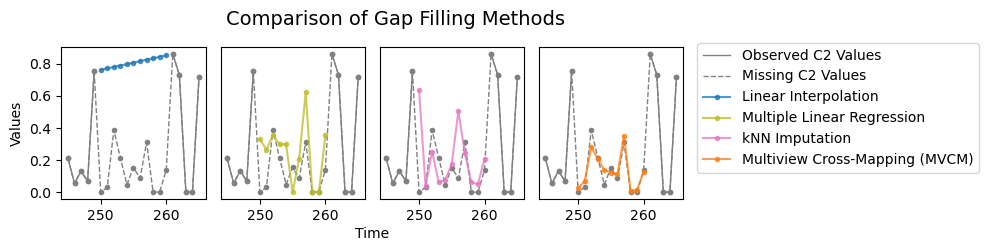

In [131]:
# Make Figure 2

target = 'C2'
noise_level = 0.0

# Get data with gap
data = pd.read_csv('../Data/Five_Species_Coupled_Food_Chain_Model_res_13.csv', index_col=0).iloc[:30000,1:]
data_subset = data.loc[904:1204,:].copy()
data_subset = data_subset.reset_index(drop=True)

lib = '1 301'
pred = '1 301'

specific_gap = [250,260]

# Add gap in target variable
gap_free_data = data_subset.copy()
data_subset.loc[specific_gap[0]:specific_gap[1],target] = None

# Get noisy data and block
noisy_data, noise_levels = get_noisy_data(data_subset, noise_level, noise, noise_scaling)
block = get_block(noisy_data, num_lags=4)

mvcm_gap_filling_example = pd.read_csv('mvcm_gap_filling_example_figure_2.csv', index_col=0)
mlr_gap_filling_example = pd.read_csv('mlr_gap_filling_example_figure_2.csv')
knn_gap_filling_example = pd.read_csv('knn_gap_filling_example_figure_2.csv')
interp_gap_filling_example = pd.read_csv('linear_interpolation_gap_filling_example_figure_2.csv')

gap_filling_example = pd.concat([mvcm_gap_filling_example, mlr_gap_filling_example[f'filtered_{target}'], knn_gap_filling_example[f'filtered_{target}'], interp_gap_filling_example[f'filtered_{target}']], axis=1)
gap_filling_example.columns = [f'missing {target} values', f'noisy_{target}', f'mvcm_{target}', f'mlr_{target}', f'knn_{target}', f'interpolated_{target}']
gap_filling_example = gap_filling_example[[f'missing {target} values', f'mvcm_{target}', f'mlr_{target}', f'knn_{target}', f'interpolated_{target}']]
gap_filling_example[f'gap_{target}'] = data_subset[target]

gap_filling_example = gap_filling_example.loc[245:265,:]
gap_filling_example.loc[245:249,[f'mvcm_{target}', f'mlr_{target}', f'knn_{target}', f'interpolated_{target}']] = np.nan
gap_filling_example.loc[261:265,[f'mvcm_{target}', f'mlr_{target}', f'knn_{target}', f'interpolated_{target}']] = np.nan

alpha=0.75
fig, axs = plt.subplots(1,4,figsize=(10,2.4))
i = 0
for method, color in zip(['interpolated', 'mlr', 'knn', 'mvcm'], ['tab:blue', 'tab:olive', 'tab:pink', 'tab:orange']):
    gap_filling_example.plot(ax=axs[i], y=[f'missing {target} values', f'gap_{target}'], color=['gray', 'gray'], style=['.--', '.-'], linewidth=1, markersize=6, legend=False)
    gap_filling_example.plot(ax=axs[i], y=[f'{method}_{target}'], color=color, style='.-', linewidth=1.5, markersize=6, legend=False, alpha=alpha)
    if i > 0:
        axs[i].set_yticks([])
    i += 1
fig.suptitle('Comparison of Gap Filling Methods', fontsize=14, position=(0.40, 0.95))
axs[0].set_ylabel('Values', fontsize=10)
fig.text(0.5,0, 'Time', fontsize=10, position=(0.36,0))
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='gray', lw=1, linestyle='-'),
    Line2D([0], [0], color='gray', lw=1, linestyle='--'),
    Line2D([0], [0], color='tab:blue', lw=1.5, linestyle='-', marker='.', alpha=alpha),
    Line2D([0], [0], color='tab:olive', lw=1.5, linestyle='-', marker='.', alpha=alpha),
    Line2D([0], [0], color='tab:pink', lw=1.5, linestyle='-', marker='.', alpha=alpha),
    Line2D([0], [0], color='tab:orange', lw=1.5, linestyle='-', marker='.', alpha=alpha)
]
legend_labels = ['Observed C2 Values', 'Missing C2 Values', 'Linear Interpolation', 'Multiple Linear Regression', 'kNN Imputation', 'Multiview Cross-Mapping (MVCM)']
legend = plt.legend(custom_lines, legend_labels, loc='center left', bbox_to_anchor=(1.05, 0.60), fontsize=10)
plt.tight_layout()
plt.show()

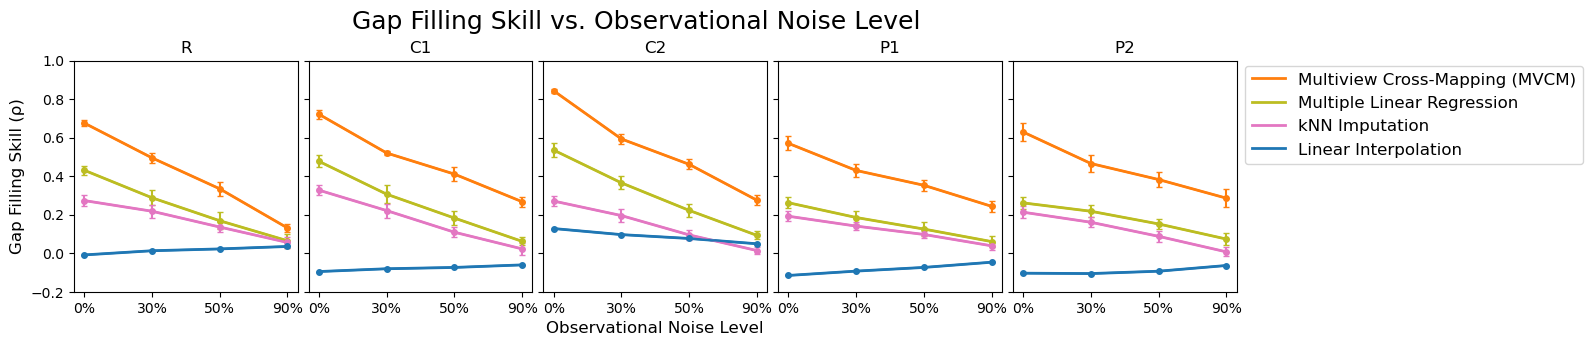

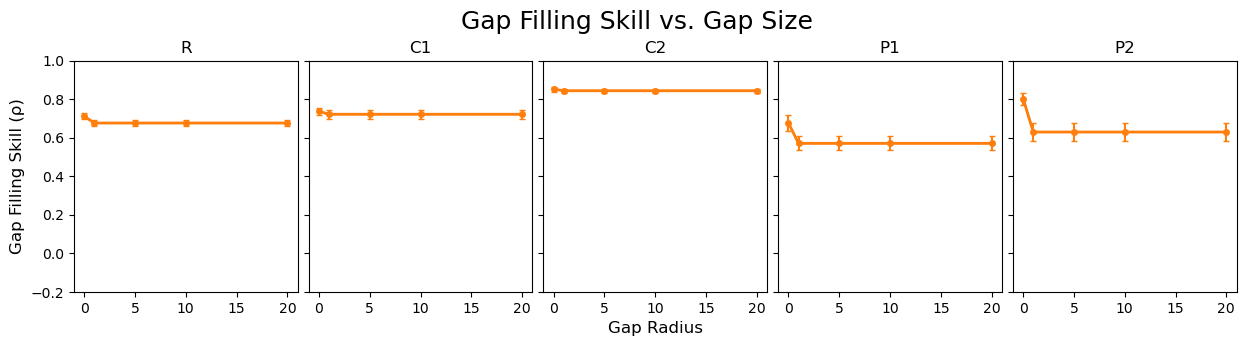

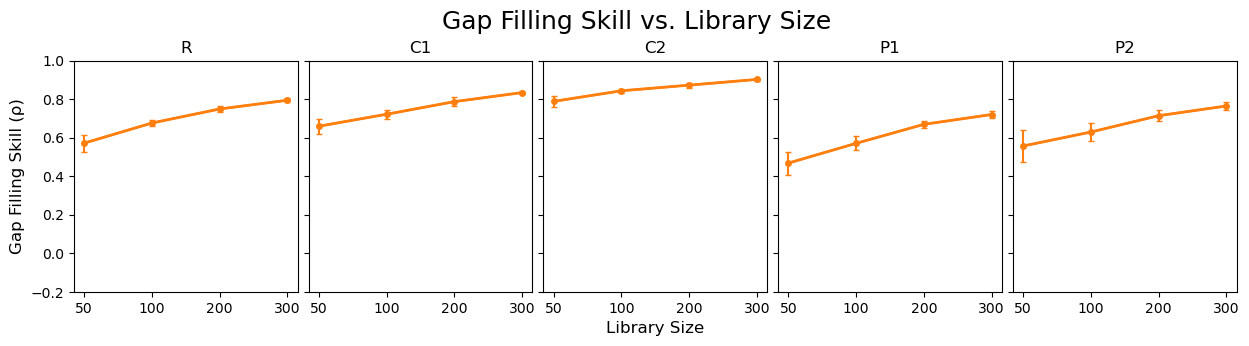

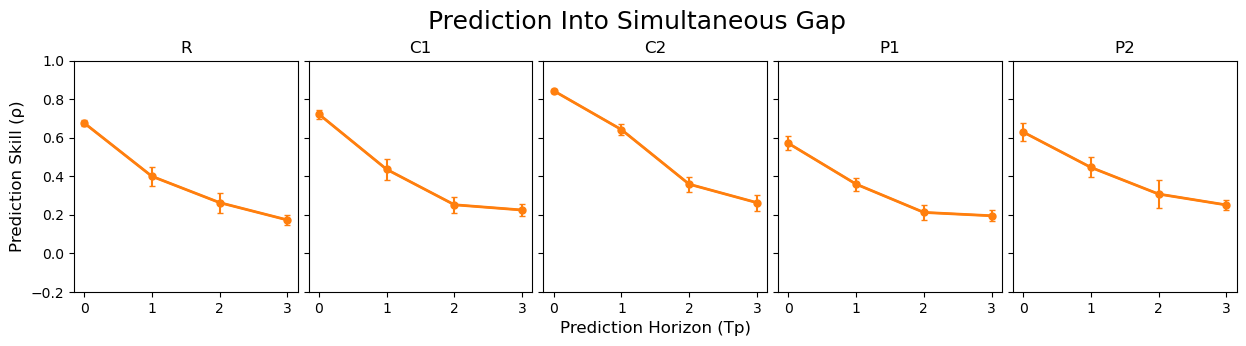

In [136]:
################################################ GAP FILLING SKILL VS. NOISE ########################################################

# Load mvcm gapfill results
with open('mvcm_gapfill_vs_noise_results.pkl', 'rb') as f:
    mvcm_gapfill_results = pickle.load(f)
    
with open('mlr_gapfill_vs_noise_results.pkl', 'rb') as f:
    mlr_gapfill_results = pickle.load(f)
    
with open('knn_gapfill_vs_noise_results.pkl', 'rb') as f:
    knn_gapfill_results = pickle.load(f)
    
with open('linear_interpolation_gapfill_vs_noise_results.pkl', 'rb') as f:
    linear_interpolation_gapfill_results = pickle.load(f)

all_gapfill_results = {} 
all_gapfill_results['mvcm'] = mvcm_gapfill_results
all_gapfill_results['mlr'] = mlr_gapfill_results
all_gapfill_results['knn'] = knn_gapfill_results
all_gapfill_results['interp'] = linear_interpolation_gapfill_results
    
# Create a figure with GridSpec
fig = plt.figure(figsize=(15, 3))
gs = fig.add_gridspec(1, 5, wspace=0.05, hspace=1.0)

# Variables for plotting
targets = ['R', 'C1', 'C2', 'P1', 'P2']

axes = []
labels = ['Multiview Cross-Mapping (MVCM)', 'Multiple Linear Regression', 'kNN Imputation', 'Linear Interpolation']
colors = ['tab:orange', 'tab:olive', 'tab:pink', 'tab:blue']
for i, target in enumerate(targets):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)
    
    for j, method in enumerate(['mvcm', 'mlr', 'knn', 'interp']):

        target_gapfill_results = all_gapfill_results[method][all_gapfill_results[method].target==target]

        libsize_vs_gapfill_means = target_gapfill_results[['noise_level', 'rho']].groupby('noise_level').mean()
        libsize_vs_gapfill_sem = target_gapfill_results[['noise_level', 'rho']].groupby('noise_level').sem()

        means_df = libsize_vs_gapfill_means.copy(); means_df.columns = [f'{method}_{target}']
        sems_df = libsize_vs_gapfill_sem.copy(); sems_df.columns = [f'{method}_{target}']
        conf_intervals = 1.96 * sems_df
        
        means_df['noise_level'] = ['0%', '30%', '50%', '90%']
        conf_intervals['noise_level'] = ['0%', '30%', '50%', '90%']
        means_df = means_df.set_index('noise_level')
        conf_intervals = conf_intervals.set_index('noise_level')

        ax.plot(means_df.index, means_df[f'{method}_{target}'], color=colors[j], label=labels[j], linewidth=2)
        ax.errorbar(means_df.index, means_df[f'{method}_{target}'], yerr=conf_intervals[f'{method}_{target}'], fmt='-o', label=None, color=colors[j], capsize=2, markersize=4)
        
        if i == 0:
            ax.set_ylabel('Gap Filling Skill (ρ)', fontsize=12)
        else:
            ax.set_yticklabels('')
        if i == 2:
            ax.set_xlabel('Observational Noise Level', fontsize=12)
    
    ax.set_ylim(-0.2, 1.0)
    ax.set_title(target)

# Suptitle and Legend
fig.suptitle('Gap Filling Skill vs. Observational Noise Level', x=0.5, y=1.05, ha='center', fontsize=18)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.7), fontsize=12)
plt.show()

################################################ GAP FILLING SKILL VS. GAP SIZE #####################################################

# Load mvcm gapfill results
with open('mvcm_gapfill_vs_gapsize_results.pkl', 'rb') as f:
    mvcm_gapfill_results = pickle.load(f)

gap_radii = [0, 1, 2, 3, 4, 5, 10, 20]
show = [0, 1, 5, 10, 20]

all_gapfill_results = {} 
all_gapfill_results['mvcm'] = mvcm_gapfill_results
    
# Create a figure with GridSpec
fig = plt.figure(figsize=(15, 3))
gs = fig.add_gridspec(1, 5, wspace=0.05, hspace=1.0)

# Variables for plotting
targets = ['R', 'C1', 'C2', 'P1', 'P2']

axes = []
labels = ['Multiview Cross-Mapping (MVCM)']
colors = ['tab:orange']
for i, target in enumerate(targets):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)
    
    for j, method in enumerate(['mvcm']):

        target_gapfill_results = all_gapfill_results[method][all_gapfill_results[method].target==target]
        gapsize_vs_gapfill_means = target_gapfill_results[['gap_radius', 'rho']].groupby('gap_radius').mean()
        gapsize_vs_gapfill_sem = target_gapfill_results[['gap_radius', 'rho']].groupby('gap_radius').sem()

        means_df = gapsize_vs_gapfill_means.copy(); means_df.columns = [f'{method}_{target}']
        sems_df = gapsize_vs_gapfill_sem.copy(); sems_df.columns = [f'{method}_{target}']
        conf_intervals = 1.96 * sems_df
            
        last_index = means_df.index[-1]
            
        for gap_radius in gap_radii:
            if gap_radius not in means_df.index:
                means_df.loc[gap_radius,f'{method}_{target}'] = means_df.loc[last_index,f'{method}_{target}']
                conf_intervals.loc[gap_radius,f'{method}_{target}'] = conf_intervals.loc[last_index,f'{method}_{target}']
                
        # Subset to gap radii you want to show
        means_df = means_df.loc[show]
        conf_intervals = conf_intervals.loc[show]

        ax.plot(means_df.index, means_df[f'{method}_{target}'], color=colors[j], label=labels[j], linewidth=2)
        ax.errorbar(means_df.index, means_df[f'{method}_{target}'], yerr=conf_intervals[f'{method}_{target}'], fmt='-o', label=None, color=colors[j], capsize=2, markersize=4)
        
        if i == 0:
            ax.set_ylabel('Gap Filling Skill (ρ)', fontsize=12)
        else:
            ax.set_yticklabels('')
        if i == 2:
            ax.set_xlabel('Gap Radius', fontsize=12)
    
    ax.set_ylim(-0.2, 1.0)
    ax.set_xticks(np.linspace(0,20,5))
    ax.set_title(target)

# Suptitle and Legend
fig.suptitle('Gap Filling Skill vs. Gap Size', x=0.5, y=1.05, ha='center', fontsize=18)
plt.show()

################################################ GAP FILLING SKILL VS. LIBRARY SIZE #####################################################

# Load mvcm gapfill results
with open('mvcm_gapfill_vs_libsize_results.pkl', 'rb') as f:
    mvcm_gapfill_results = pickle.load(f)

all_gapfill_results = {} 
all_gapfill_results['mvcm'] = mvcm_gapfill_results
  
# Create a figure with GridSpec
fig = plt.figure(figsize=(15, 3))
gs = fig.add_gridspec(1, 5, wspace=0.05, hspace=1.0)

# Variables for plotting
targets = ['R', 'C1', 'C2', 'P1', 'P2']
libsizes = ['50', '100', '200', '300']

axes = []
labels = ['Multiview Cross-Mapping (MVCM)']
colors = ['tab:orange']
for i, target in enumerate(targets):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)
    
    for j, method in enumerate(['mvcm']):

        target_gapfill_results = all_gapfill_results[method][all_gapfill_results[method].target==target]

        libsize_vs_gapfill_means = target_gapfill_results[['libsize', 'rho']].groupby('libsize').mean()
        libsize_vs_gapfill_means = libsize_vs_gapfill_means.loc[libsizes]

        libsize_vs_gapfill_sem = target_gapfill_results[['libsize', 'rho']].groupby('libsize').sem()
        libsize_vs_gapfill_sem = libsize_vs_gapfill_sem.loc[libsizes]

        means_df = libsize_vs_gapfill_means.copy(); means_df.columns = [f'{method}_{target}']
        sems_df = libsize_vs_gapfill_sem.copy(); sems_df.columns = [f'{method}_{target}']
        conf_intervals = 1.96 * sems_df

        ax.plot(means_df.index, means_df[f'{method}_{target}'], color=colors[j], label=labels[j], linewidth=2)
        ax.errorbar(means_df.index, means_df[f'{method}_{target}'], yerr=conf_intervals[f'{method}_{target}'], fmt='-o', label=None, color=colors[j], capsize=2, markersize=4)
        
        if i == 0:
            ax.set_ylabel('Gap Filling Skill (ρ)', fontsize=12)
        else:
            ax.set_yticklabels('')
        if i == 2:
            ax.set_xlabel('Library Size', fontsize=12)
    
    ax.set_ylim(-0.2, 1.0)
    ax.set_title(target)

# Suptitle and Legend
fig.suptitle('Gap Filling Skill vs. Library Size', x=0.5, y=1.05, ha='center', fontsize=18)

plt.show()

################################################ GAP FILLING SKILL VS. Tp ###########################################################

# Load mvcm gapfill results

with open('averaged_mvcm_gapfill_vs_Tp_results.pkl', 'rb') as f:
    mvcm_gapfill_results = pickle.load(f)

all_gapfill_results = {} 
all_gapfill_results['mvcm'] = mvcm_gapfill_results
    
# Create a figure with GridSpec
fig = plt.figure(figsize=(15, 3))
gs = fig.add_gridspec(1, 5, wspace=0.05, hspace=1.0)

# Variables for plotting
targets = ['R', 'C1', 'C2', 'P1', 'P2']
noise_levels = [0.0]
libsizes = ['50', '100', '200', '300']

axes = []
labels = ['Multiview Cross-Mapping (MVCM)']
colors = ['tab:orange']
for i, target in enumerate(targets):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)
    
    for j, method in enumerate(['mvcm']):

        target_gapfill_results = all_gapfill_results[method][all_gapfill_results[method].target==target]

        libsize_vs_gapfill_means = target_gapfill_results[['Tp', 'rho']].groupby('Tp').mean()
        libsize_vs_gapfill_sem = target_gapfill_results[['Tp', 'rho']].groupby('Tp').sem()

        means_df = libsize_vs_gapfill_means.copy(); means_df.columns = [f'{method}_{target}']
        sems_df = libsize_vs_gapfill_sem.copy(); sems_df.columns = [f'{method}_{target}']
        conf_intervals = 1.96 * sems_df
        
        means_df = means_df[means_df.index >= 0]
        conf_intervals = conf_intervals[conf_intervals.index >= 0]

        ax.plot(means_df.index, means_df[f'{method}_{target}'], color=colors[j], label=labels[j], linewidth=2)
        ax.errorbar(means_df.index, means_df[f'{method}_{target}'], yerr=conf_intervals[f'{method}_{target}'], fmt='-o', label=None, color=colors[j], capsize=2, markersize=5)
        
        if i == 0:
            ax.set_ylabel('Prediction Skill (ρ)', fontsize=12)
        else:
            ax.set_yticklabels('')
        if i == 2:
            ax.set_xlabel('Prediction Horizon (Tp)', fontsize=12)
    
    ax.set_ylim(-0.2, 1.0)
    ax.set_title(target)

# Suptitle and Legend
fig.suptitle('Prediction Into Simultaneous Gap', x=0.5, y=1.05, ha='center', fontsize=18)
plt.show()

# Lake Zurich Gap Filling

### Load Data

In [37]:
# Load Lake Zurich Data (data has been normalized by min-max normalizing between 0 and 1 and then taking the square root)
LZ_data = pd.read_csv('../Data/LZ_data.csv', index_col=0).iloc[1:,:]
LZ_data.columns = LZ_data.columns.str.replace(' ', '_')

# Put columns in alphabetical order
sorted_columns = sorted(LZ_data.columns)
LZ_data = LZ_data[sorted_columns]

# Make indices integers and save mapping to dates
date_to_int_map = {i: date for i, date in enumerate(LZ_data.index)}
LZ_data.index = range(len(LZ_data))

target = 'Planktothrix_rubescens'
block = get_block(LZ_data, num_lags=50, tau=1)

### Choose Dynamically Coupled Variables Using CCM

In [39]:
def ccm(interaction, block, E_list, tau_list, theta_list, Tp, sample=50, sig=0.05):
    
    lib = f'1 {len(block)}'
    
    # Get dataframe with two species of interest
    A = interaction[0]; B = interaction[1]
    df = block[[f'{A}(t-0)', f'{B}(t-0)']]
    
    driver = f'{A}(t-0)'
    
    E_tau_theta_results = pd.DataFrame(columns = ['E', 'tau', 'theta', 'rho'])
    for E, tau, theta in list(product(E_list, tau_list, theta_list)):
        driven_embedded = [f'{B}(t{i})' if i < 0 else f'{B}(t-{i})' for i in range(E * tau, 1)]
        driven_embedded = driven_embedded[::tau][:E]
        c = SMap(dataFrame=block, target=driver, columns=driven_embedded, embedded=True, Tp=Tp, theta=theta, lib=lib, pred=lib, noTime=True)
        c = c['predictions'][['Observations', 'Predictions']]
        rho = c.corr().iloc[0,1]
        E_tau_theta_results.loc[len(E_tau_theta_results)] = [E, tau, theta, rho]
    E_tau_theta_results = E_tau_theta_results.apply(pd.to_numeric, errors='coerce')

    # Assign E, tau, and theta to be the optimal E, tau, and theta
    ccm_value = E_tau_theta_results['rho'].max()
    E = int(E_tau_theta_results.loc[np.where(E_tau_theta_results.rho==ccm_value),'E'].item())
    tau = int(E_tau_theta_results.loc[np.where(E_tau_theta_results.rho==ccm_value),'tau'].item())
    theta = int(E_tau_theta_results.loc[np.where(E_tau_theta_results.rho==ccm_value),'theta'].item())
        
    # Get convergence p-value
    convergence_p_value = get_convergence_p_value(block, sample, A, B, E, Tp, tau, theta)

    # Preparing Output
    output = {
        'target (driver)': A,
        'lib (driven)': B,
        'E': E,
        'tau': tau,
        'theta': theta,
        'E_tau_theta_results': E_tau_theta_results,
        'ccm_value': ccm_value,
        'convergence_p_value': convergence_p_value,
        'correlation': df.corr().iloc[0,1]
    }

    return output

def get_convergence_p_value(df, sample, A, B, E, Tp, tau, theta):
    # Get convergence p-value for CCM (one-tailed t-test on cross-map values using 20% and 50% library sizes)
    # H0: μ_20% ≥ μ_50%
    # HA: μ_20% < μ_50%
    # If p < 0.05, the 20% library size trials have a rho that is significantly smaller than the 50% library trials  
    
    libsize1 = int(np.ceil(df.shape[0]/5))   # 20% of the full library size
    libsize2 = int(np.ceil(df.shape[0]/2))   # 50% of the full library size
    
    max_iterations = 10 * sample
    
    # Get list of rhos for libsize1
    rhos1 = []; iteration_count = 0
    while len(rhos1) < sample and iteration_count < max_iterations:
        start = np.random.randint(libsize1, len(df))
        library = [start - libsize1, start]
        data_subset = df.iloc[library[0]:library[1]]
        lib = f'{library[0]+1} {library[1]+1}'
        driver = f'{A}(t-0)'
        driven_embedded = [f'{B}(t{i})' if i < 0 else f'{B}(t-{i})' for i in range(E * tau, 1)]
        driven_embedded = driven_embedded[::tau][:E]
        c = SMap(dataFrame=block, target=driver, columns=driven_embedded, embedded=True, Tp=Tp, theta=theta, lib=lib, pred=lib, noTime=True)
        c = c['predictions'][['Observations', 'Predictions']]
        rho1 = c.corr().iloc[0,1]
        if not np.isnan(rho1):
            rhos1.append(rho1)
        iteration_count += 1
        
    # Get list of rhos for libsize2
    rhos2 = []; iteration_count = 0
    while len(rhos2) < sample and iteration_count < max_iterations:
        start = np.random.randint(libsize2, len(df))
        library = [start - libsize2, start]
        data_subset = df.iloc[library[0]:library[1]]
        lib = f'{library[0]+1} {library[1]+1}'
        driver = f'{A}(t-0)'
        driven_embedded = [f'{B}(t{i})' if i < 0 else f'{B}(t-{i})' for i in range(E * tau, 1)]
        driven_embedded = driven_embedded[::tau][:E]
        c = SMap(dataFrame=block, target=driver, columns=driven_embedded, embedded=True, Tp=Tp, theta=theta, lib=lib, pred=lib, noTime=True)
        c = c['predictions'][['Observations', 'Predictions']]
        rho2 = c.corr().iloc[0,1]
        if not np.isnan(rho2):
            rhos2.append(rho2)
        iteration_count += 1
    
    convergence_t_stat, convergence_p_value = ttest_ind(rhos1, rhos2, alternative='less')
    
    return convergence_p_value

E_list = range(2,13)
tau_list = [-1,-2,-3]
theta_list = [0,0.1,0.5,1,2,3,4,5,6,7,8,9]
Tp = 0
exclusion_radius = 0

all_ccm_results = pd.DataFrame()
interactions = list(permutations(LZ_data.columns.tolist(),2))
target_interactions = [pair for pair in interactions if target in pair]

interaction = target_interactions[0]

results = Parallel(n_jobs=-1)(
    delayed(ccm)(interaction, block, E_list, tau_list, theta_list, Tp) for interaction in target_interactions)
results_df = pd.DataFrame(results)


KeyboardInterrupt



In [ ]:
# Get CCM results that show convergence (convergence p-value < 0.05)

ccm_cutoff = 0.5

significant_results = results_df[results_df.convergence_p_value<0.05]
significant_results = significant_results.sort_values(by='ccm_value', ascending=False)
significant_results = significant_results[['target (driver)', 'lib (driven)', 'E', 'tau', 'theta', 'ccm_value']].reset_index(drop=True)

display(significant_results[significant_results.ccm_value>ccm_cutoff])

# Choose system variables where the CCM value to or from the target is > ccm_cutoff
system_variables = significant_results[significant_results.ccm_value > ccm_cutoff]
system_variables = system_variables[['target (driver)', 'lib (driven)']].values.flatten().tolist()
system_variables = list(set(system_variables))
print('system variables: ')
display(sorted(system_variables))

In [ ]:
def get_valid_lags_tau(block, target, Tp, tau, num_lags, exclusion_radius, system_variables):
    
    # Get lags of system variables
    system_variable_lags = []
    for var in system_variables:
        # Get forwards and backwards lag of the system variables
        var_backwards_lags = [f'{var}(t{i})' if i < 0 else f'{var}(t-{i})' for i in range(num_lags * tau, 1)]
        var_backwards_lags = var_backwards_lags[::tau][:num_lags]
        var_forwards_lags  = [f'{var}(t+{i})' for i in range(-(num_lags-1) * tau + 1)]
        var_forwards_lags  = var_forwards_lags[::tau][:num_lags-1]
        var_lags = var_backwards_lags + var_forwards_lags
        system_variable_lags = system_variable_lags + var_lags
    
    # Remove (t-0) lag of target variable from valid_lags
    valid_lags = [x for x in system_variable_lags if x != f'{target}(t-0)']

    # If Tp = 0, remove [-exclusion_radius, exclusion_radius] lags of target variable from valid lags
    if Tp == 0:
        for r in range(-exclusion_radius, exclusion_radius+1):
            if r < 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t{r})']
            elif r == 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t-{r})']
            elif r > 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t+{r})']
                    
    return valid_lags

target = 'Planktothrix_rubescens'
system_variables = system_variables
Tp = 0
exclusion_radius = 6
num_lags = 2   # Use -3, 0, and +3 lags of each variable
tau = -3

valid_lags = get_valid_lags_tau(block, target, Tp, tau, num_lags, exclusion_radius, system_variables)

In [ ]:
random_embeddings = {}
for E in range(4,26):
    # Get random embeddings using valid lags
    embeddings = set()
    sample = 100000
    max_trials = 10000000
    trials = 0
    while len(embeddings) < sample and trials < max_trials:
        embedding = tuple(random.sample(valid_lags, E))
        sorted_embedding = tuple(sorted(embedding))
        if sorted_embedding not in embeddings:
            embeddings.add(sorted_embedding)
    trials += 1
    embeddings = [list(embedding) for embedding in embeddings]
    random_embeddings['{0}'.format((target, E, Tp, exclusion_radius))] = embeddings
    print(f'E = {E}, # embeddings = {len(embeddings)}')
    
# with open('random_embeddings_LZ.pkl', 'wb') as file:
#     pickle.dump(random_embeddings, file)

In [138]:
# Load LZ random embeddings
with open('random_embeddings_LZ.pkl', 'rb') as file:
    LZ_embeddings = pickle.load(file)

In [ ]:
# Create folder to store xmap results
# folder = 'xmap results LZ 100000 random embeddings'
# if not os.path.exists(folder):
#     os.makedirs(folder)

In [ ]:
# Save LZ cross-mapping results

E_list = range(4,25)
theta_list = [1,5,9,15,25,35,45]
Tp = 0
exclusion_radius = 6
self_weight = 0  # self_weight = 0 for gap filling
lib = '1 396'
pred = '1 396'

total_iterations = len(E_list) * len(theta_list)

gapfill_results = {}
parameters = pd.DataFrame(columns=['target', 'noise_level', 'lib', 'pred', 'E', 'theta', 'k', 'rho'])
block = get_block(LZ_data, num_lags=50)

with tqdm(total=total_iterations) as pbar:
    for E, theta in product(E_list, theta_list):

        key = [key for key in LZ_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == exclusion_radius]
        embeddings = LZ_embeddings[key[0]]

        xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)

        file_path = os.path.join(folder, f'xmap_results_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl')

        with open(file_path, 'wb') as f:
            pickle.dump(xmap_results, f)

        pbar.update(1)

In [ ]:
# Find optimal parameters

E_list = range(4,25)
theta_list = [1,5,9,15,25,35,45]
k_list = [3,5,10,25,50,75,100,150,200]
Tp = 0
exclusion_radius = 6
self_weight = 0  # self_weight = 0 for gap filling
lib = '1 396'
pred = '1 396'

total_iterations = len(E_list) * len(theta_list) * len(k_list)
block = get_block(LZ_data, num_lags=50)

# Get lib and pred indices, adjusted to match pyEDM
lib_start, lib_end = map(int, lib.split())
pred_start, pred_end = map(int, pred.split())
lib_start -= 1; lib_end -= 1
pred_start -= 1; pred_end -= 1

# Get multiview cross-map predictions for E, k, and theta combinations
mvcm_results = pd.DataFrame(columns=['E', 'k', 'theta', 'rho', 'noisy_and_filtered'])
with tqdm(total=total_iterations) as pbar:
    all_xmap_results = {}
    for E, theta in product(E_list, theta_list):
        with open(f'xmap results LZ 100000 random embeddings/xmap_results_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl', 'rb') as file:
            xmap_results = pickle.load(file)

        # Get multiview cross-map predictions for ks in k_list 
        for k in k_list:

            filtered = MVCM(block, target, xmap_results, Tp, exclusion_radius, theta, lib, pred, E, k, self_weight)

            # Align indices of noisy target with indices of filtered_timeseries
            noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']
            noisy_and_filtered = pd.concat([noisy_target, filtered], axis=1)
            noisy_and_filtered.columns = [f'noisy_{target}', f'filtered_{target}']
            rho = noisy_and_filtered.corr().iloc[0,1]
            mvcm_results.loc[len(mvcm_results)] = [E, k, theta, rho, noisy_and_filtered]
            pbar.update(1)

In [ ]:
# Get xmap results for optimal parameters

E = 19
theta = 45
k = 150

with open(f'xmap results LZ 100000 random embeddings/xmap_results_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl', 'rb') as file:
    xmap_results = pickle.load(file)

In [ ]:
# Re-rank xmap results for each t after applying exclusion radius to predictions

def re_rank_xmap_results(t, exclusion_radius, xmap_results):
    '''Re-rank xmap results, removing predictions within the exclusion radius for each t.'''
    start_idx = t - exclusion_radius
    end_idx = t + exclusion_radius

    # Re-rank xmap results with exclusion radius removed from predictions
    xmap_results_t = xmap_results.copy(deep=True)
    xmap_results_t['new_rho'] = None

    for idx in xmap_results.index:
        xmap_results_t.at[idx, 'result'] = xmap_results.loc[idx, 'result'].copy(deep=True)
        xmap_results_t.loc[idx,'result'].loc[start_idx:end_idx,'Predictions'] = np.nan
        new_rho = xmap_results_t.loc[idx,'result'][['Observations', 'Predictions']].corr().iloc[0,1]
        xmap_results_t.loc[idx,'new_rho'] = new_rho
    
    return t, xmap_results_t['new_rho']

exclusion_radius = 6

results = Parallel(n_jobs=10)(delayed(re_rank_xmap_results)(t, exclusion_radius, xmap_results) for t in tqdm(LZ_data.index))
results_dict = {t: new_rho for t, new_rho in results}
results_df = pd.DataFrame(results_dict)
xmap_results_for_each_t = pd.concat([xmap_results, results_df.add_prefix('new_rho_')], axis=1)

# with open(f'xmap_results_for_each_t_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl', 'wb') as f:
#     pickle.dump(xmap_results_for_each_t, f)

In [ ]:
# Filter points with a six-month exclusion radius on either side

exclusion_radius = 6
self_weight = 0
Tp = 0

LZ_gapfill_results = pd.DataFrame(columns=['reconstructed_points'])
with tqdm(total=len(LZ_data)) as pbar:
    for t in LZ_data.index:
        LZ_data_t = LZ_data.copy()
        start_idx = t - exclusion_radius
        end_idx = t + exclusion_radius
        LZ_data_t.loc[start_idx:end_idx,target] = np.nan

        block = get_block(LZ_data_t, num_lags=50)
        
        xmap_results_t = xmap_results_for_each_t.copy(deep=True)
        xmap_results_t = xmap_results_t.sort_values(by=[f'new_rho_{t}'], ascending=False).reset_index(drop=True)
        xmap_results_t = xmap_results_t[['embedding', 'result', f'new_rho_{t}']]
        xmap_results_t.columns = ['embedding', 'result', 'rho']

        filtered = MVCM(block, target, xmap_results_t, Tp, exclusion_radius, theta, lib, pred, E, k, self_weight)
        t_result = filtered.loc[t,f'filtered_points']
        LZ_gapfill_results.loc[t,'reconstructed_points'] = t_result
        pbar.update(1)

In [33]:
# Result with exclusion radius
LZ_mvcm_result = LZ_data[[target]].copy()
LZ_mvcm_result['mvcm'] = LZ_gapfill_results['reconstructed_points']
LZ_mvcm_result = LZ_mvcm_result.dropna().reset_index(drop=True)

# First three and last three results should be NaN because up to -3 and 3 months lags were used
LZ_mvcm_result.loc[0:2,'mvcm'] = np.nan
LZ_mvcm_result.loc[len(LZ_mvcm_result)-3:len(LZ_mvcm_result)-1,'mvcm'] = np.nan

NameError: name 'LZ_gapfill_results' is not defined

In [31]:
LZ_mlr_results = pd.DataFrame(columns=['mlr'])
with tqdm(total=len(LZ_data)) as pbar:
    for t in LZ_data.index[3:362]:
        LZ_data_t = LZ_data.copy()
        start_idx = t - exclusion_radius
        end_idx = t + exclusion_radius
        LZ_data_t.loc[start_idx:end_idx,target] = np.nan

        start_idx = max(t - exclusion_radius, LZ_data.index[3:362].min())
        end_idx = min(t + exclusion_radius, LZ_data.index[3:362].max())

        block = get_block(LZ_data_t, num_lags=3)
        block = block.drop(columns=[f'{target}(t-3)', f'{target}(t-2)', f'{target}(t-1)',
                            f'{target}(t+1)', f'{target}(t+2)', f'{target}(t+3)'])

        block = block.loc[3:361,:]

        predictor_variables = block.copy().drop(columns=[f'{target}(t-0)'])
        target_variable = block[[f'{target}(t-0)']].copy()

        train_idxs = list(range(block.index[0],start_idx))+list(range(end_idx+1,block.index[len(block)-1]))
        test_idxs = list(range(start_idx,end_idx+1))

        X_train = predictor_variables.loc[train_idxs,:]
        y_train = target_variable.loc[train_idxs,:]

        X_test = predictor_variables.loc[test_idxs,:]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predicted_value = y_pred[6][0]

        if predicted_value < 0:
            predicted_value = 0

        LZ_mlr_results.loc[t,'mlr'] = predicted_value

        pbar.update(1)

  0%|                                                   | 0/396 [00:00<?, ?it/s]


IndexError: index 6 is out of bounds for axis 0 with size 1

In [ ]:
# Result with exclusion radius
LZ_mlr_result = LZ_data[[target]].copy()
LZ_mlr_result['mlr'] = LZ_mlr_results['mlr']
LZ_mlr_result = LZ_mlr_result.dropna().reset_index(drop=True)

# LZ_mlr_result.to_csv('exclusion_radius_LZ_mlr_result_scikit_learn.csv')

In [ ]:
# kNN Imputation

# Assuming LZ_data and target variable are defined
exclusion_radius = 6
LZ_knn_results = pd.DataFrame(columns=['knn'])

# Initialize the KNeighborsRegressor
num_nns_list = range(2,10)

with tqdm(total=len(LZ_data)-37) as pbar:
    for t in LZ_data.index[3:362]:
        
        LZ_data_t = LZ_data.copy()
        start_idx = t - exclusion_radius
        end_idx = t + exclusion_radius
        LZ_data_t.loc[start_idx:end_idx,target] = np.nan

        start_idx = max(t - exclusion_radius, LZ_data.index[3:362].min())
        end_idx = min(t + exclusion_radius, LZ_data.index[3:362].max())

        block = get_block(LZ_data_t, num_lags=3)
        block = block.drop(columns=[f'{target}(t-3)', f'{target}(t-2)', f'{target}(t-1)',
                            f'{target}(t+1)', f'{target}(t+2)', f'{target}(t+3)'])

        block = block.loc[3:361,:]

        predictor_variables = block.copy().drop(columns=[f'{target}(t-0)'])
        target_variable = block[[f'{target}(t-0)']].copy()

        train_idxs = list(range(block.index[0],start_idx))+list(range(end_idx+1,block.index[len(block)-1]))
        test_idxs = list(range(start_idx,end_idx+1))

        X_train = predictor_variables.loc[train_idxs,:]
        y_train = target_variable.loc[train_idxs,:]

        X_test = predictor_variables.loc[test_idxs,:]

        # Impute missing target values using kNN
        knn_imputer = KNeighborsRegressor(n_neighbors=k)
        knn_imputer.fit(X_train, y_train)
        
        # Optimize number of nearest neighbors by rho value
        optimize_num_nns = pd.DataFrame(columns=['num_nns', 'rho'])
        for num_nns in num_nns_list:
            knn_imputer = KNeighborsRegressor(n_neighbors=num_nns)
            knn_imputer.fit(X_train, y_train)
            predictions = pd.DataFrame(knn_imputer.predict(X_train), columns=['Predicted'], index = X_train.index)
            predictions['Observed'] = y_train
            rho = predictions.corr().iloc[0,1]
            optimize_num_nns.loc[len(optimize_num_nns)] = [num_nns, rho]
        optimize_num_nns = optimize_num_nns.sort_values(by='rho', ascending=False).reset_index(drop=True)
        
        num_nns = int(optimize_num_nns.loc[0,'num_nns'])
        
        # Fit kNN Imputer with optimal number of nearest neighbors
        knn_imputer = KNeighborsRegressor(n_neighbors=k)
        knn_imputer.fit(X_train, y_train)
            
        # Impute the target variable for missing values
        y_train_imputed = knn_imputer.predict(X_test)
        predicted_value = y_train_imputed[6][0]

        if predicted_value < 0:
            predicted_value = 0

        LZ_knn_results.loc[t,'knn'] = predicted_value
        
        pbar.update(1)

In [ ]:
# Result with exclusion radius
LZ_knn_result = LZ_data[[target]].copy()
LZ_knn_result['knn'] = LZ_knn_results['knn']
LZ_knn_result = LZ_knn_result.dropna().reset_index(drop=True)
LZ_knn_result.index = range(3,362)

# LZ_knn_result.to_csv('exclusion_radius_LZ_knn_result_scikit_learn.csv')

In [ ]:
# Linear interpolation
interpolated = linear_interpolation(block, target, Tp, exclusion_radius, pred)

LZ_interpolation_result = LZ_data[[target]].copy()
LZ_interpolation_result['interpolated'] = interpolated[f'interpolated_{target}']
LZ_interpolation_result = LZ_interpolation_result.dropna().reset_index(drop=True)
#LZ_interpolation_result.index = range(3,362)

display(LZ_interpolation_result.corr())

In [ ]:
# Format result with dates

LZ_gapfilling_results = pd.concat([LZ_mvcm_result, LZ_mlr_result['mlr'], LZ_knn_result['knn']], axis=1)

LZ_gapfilling_results['date'] = LZ_gapfilling_results.index.map(date_to_int_map)

LZ_gapfilling_results = LZ_gapfilling_results.set_index('date')
#LZ_gapfilling_results.to_csv('Lake_Zurich_gap_filling_results_with_dates.csv')

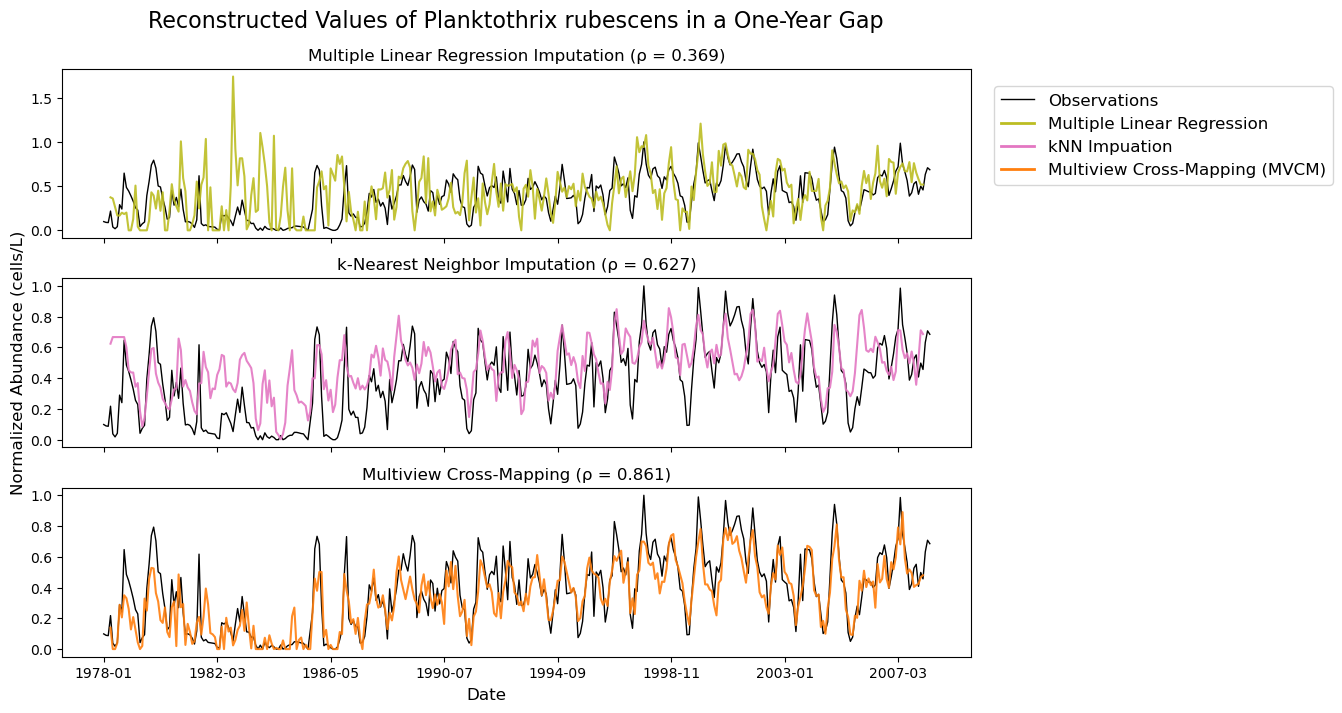

In [139]:
# Make figure

final_result_with_dates = pd.read_csv('Lake_Zurich_gap_filling_results_with_dates.csv', index_col=0)
target = 'Planktothrix_rubescens'

fig, axs = plt.subplots(3, 1, figsize=(10,7), sharex=True)

rhos = final_result_with_dates.corr().iloc[[0],:]

# Plot for mlr_target
final_result_with_dates.plot(y=[target], color=['k'], ax=axs[0], legend=False, linewidth=1)
final_result_with_dates.plot(y=['mlr'], color=['tab:olive'], ax=axs[0], legend=False, alpha=0.9)
axs[0].set_title(f"Multiple Linear Regression Imputation (ρ = {str(round(rhos[f'mlr'].item(),3))})")

# Plot for knn_target
final_result_with_dates.plot(y=[target], color=['k'], ax=axs[1], legend=False, linewidth=1)
final_result_with_dates.plot(y=['knn'], color=['tab:pink'], ax=axs[1], legend=False, alpha=0.9)
axs[1].set_title(f"k-Nearest Neighbor Imputation (ρ = {str(round(rhos[f'knn'].item(),3))})")
axs[1].set_xlabel('')  # Remove x-axis label
axs[1].set_ylabel('Normalized Abundance (cells/L)', fontsize=12)

# Plot for mvcm_target
final_result_with_dates.plot(y=[target], color=['k'], ax=axs[2], legend=False, linewidth=1)
final_result_with_dates.plot(y=['mvcm'], color=['tab:orange'], ax=axs[2], legend=False, alpha=0.9)
axs[2].set_title(f"Multiview Cross-Mapping (ρ = {str(round(rhos[f'mvcm'].item(),3))})")
axs[2].set_xlabel('')  # Remove x-axis label

fig.text(0.5, 0.00, 'Date', ha='center', va='center', fontsize=12)
fig.suptitle('Reconstructed Values of Planktothrix rubescens in a One-Year Gap', x=0.53, fontsize=16)

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', lw=1, label='Observations'),
                   Line2D([0], [0], color='tab:olive', lw=2, label='Multiple Linear Regression'),
                   Line2D([0], [0], color='tab:pink', lw=2, label='kNN Impuation'),
                   Line2D([0], [0], color='tab:orange', lw=2, label='Multiview Cross-Mapping (MVCM)')
                   ]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.8), fontsize=12)

plt.tight_layout()
plt.show()